# Roubust Autoencoder Notebook
This notebook is reference to the original paper [Robust Auto-encoders](https://web.wpi.edu/Pubs/ETD/Available/etd-042716-153627/unrestricted/czhou.pdf) and [Anomaly Detection with Robust Deep Autoencoders](https://www.eecs.yorku.ca/course_archive/2017-18/F/6412/reading/kdd17p665.pdf)  

###Necessary library and corresponding version:  
numpy version:  1.18.5  
pytorch version:  1.7.0+cu101  
torchvision version:  0.8.1+cu101  
matplotlib version:  3.2.2

In [ ]:
# Import necessary library

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import random

In [ ]:
# Package requirement

print('numpy version: ', np.__version__)
print('pytorch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)
print('matplotlib version: ', matplotlib.__version__)

numpy version:  1.18.5
pytorch version:  1.7.0+cu101
torchvision version:  0.8.1+cu101
matplotlib version:  3.2.2


In [ ]:
# Set random seed for reproductibility

seed = 42
torch.manual_seed(seed)

# Data Preparation

In [ ]:
# Load PyTorch MNIST dataset

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, download=True,
    transform=transform
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Create training data using numpy array

xtrain = []
ytrain = []
for x, y in train_dataset:
  xtrain.append(x.numpy())
  ytrain.append(y)

In [ ]:
# Manual create sub dataset for the purpose of outliers detection
# Choose 4000 samples of digit 4 as normal data and 182 random samples of not digit 4 as outliers
# Total number of samples in the sub dataset is 4182. The index(0, 3999) is digit 4 and the index(4000, 4181) is not digit 4

indices = [i for i, x in enumerate(ytrain) if x == 4]
indices = indices[0:4000]

rand = []
for i in range(200):
  randidx = random.randint(0, 60000)
  if ytrain[randidx] != 4:
    rand.append(randidx)

index = indices + rand
xtrain_1 = []
ytrain_1 = []
for i in index:
  xtrain_1.append(xtrain[i])
  ytrain_1.append(ytrain[i])

# Autoencoder Model
Input layer shape: 784, hidden layers shape 256-32-256, output layer shape: 784

In [ ]:
# Autoencoder model class
# Input layer shape: 784, hidden layers shape 256-32-256, output layer shape: 784

class RAE(nn.Module):
  def __init__(self):
    super(RAE, self).__init__()

    self.enc1 = nn.Linear(in_features=784, out_features=256)
    self.enc2 = nn.Linear(in_features=256, out_features=32)

    self.dec1 = nn.Linear(in_features=32, out_features=256)
    self.dec2 = nn.Linear(in_features=256, out_features=784)

  def forward(self, x):

    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))

    x = F.relu(self.dec1(x))
    x = F.relu(self.dec2(x))

    return x

# Necessary Functions

In [ ]:
# Training function

def training(model, epoch, train_loader):
  train_loss = []
  val_loss = []
  for e in range(epoch):
    running_loss = 0
    for data, _ in train_loader:
      input = data
      input = input.view(-1, 784)
      output = model(input)
      loss = criterion(input, output)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      running_loss += loss.item()

    ave_loss = running_loss / len(train_loader)
    train_loss.append(ave_loss)
    #print('Train loss at {}/{} epoch is {}'.format(e+1, epoch, ave_loss))

  return train_loss

# Shrinkage function based on the original paper

# L1 shrinkage
def shrinkage(S, lamda):
  for i in range(np.shape(S)[0]):
    for j in range(np.shape(S)[1]):
      if S[i, j] > lamda:
        S[i, j] = S[i, j] - lamda
      if S[i, j] < -lamda:
        S[i, j] = S[i, j] + lamda
      if S[i, j] <= lamda and S[i, j] >= -lamda:
        S[i, j] = 0
  return S

# L12 shrinkage
def l12shrinkage(S, lamda):
  for j in range(np.shape(S)[1]):
    e = np.sqrt(np.sum(S[:, j]**2))
    if e > lamda:
      for i in range(np.shape(S)[0]):
        S[i, j] = S[i, j] - lamda * S[i, j]/e

    if e <= lamda:
      for i in range(np.shape(S)[0]):
        S[i, j] = 0
  return S

#Robust Autoencoder Training Process
## L12 Shrinkage

In [ ]:
# Choose lambda value from 1e-7 to 1e-6 in step of 1e-7

#lambda_number = [x * 1e-8 for x in range(1, 101, 5)]
lambda_number = [1e-8, 2.5e-8, 5e-8, 7.5e-8, 1e-7, 2.5e-7, 5e-7, 7.5e-7, 1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5, 2.5e-5, 5e-5, 7.5e-5]
f1_score_lst = []
precision_lst = []
recall_lst = []
acc_lst = []
out_dict = {}

for lambda_value in lambda_number:

  # initialization
  S = np.zeros((len(xtrain_1), 784))
  output = np.zeros((len(xtrain_1), 784))
  epsilon = 1e-7
  X = np.array(xtrain_1).reshape((len(xtrain_1), 784))
  y = np.array(ytrain_1)
  LS = X

  j = 0

  while j < 50:
    # Define the LD matrix for this step
    LD = X - S

    # Autoencoder step on LD substracted from S
    LD_tensor = torch.from_numpy(LD).float()
    y_tensor = torch.from_numpy(y).float()
    train_dataset = torch.utils.data.TensorDataset(LD_tensor, y_tensor)
    # Create data loader and use batch size = 128
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = False)

    # Initiate the model and use MSE loss, learning rate = 0.001 and epochs = 10
    model = RAE()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    training(model, 10, train_loader)

    # Autoencoder of the step trained, so extraction of the output.
    i = 1
    for input, _ in train_loader:
      input = input.view(-1, 784)
      if i == 1:
        output1 = model(input)
        output1 = output1.detach().numpy()
        output = output1
      else:
        output2 = model(input)
        output2 = output2.detach().numpy()
        output = np.concatenate((output, output2), axis=0)
      i += 1

    """
    LD = np.zeros_like(X)
    i = 0
    for input, _ in train_loader:
      input = input.view(-1, 784)
      output = model(input).detach().numpy()
      LD[i, :] = output
      i += 1
    """

    # Update LD as the reconstruction by the autoencoder
    LD = output

    # Compute S and apply shrinkage.
    S = X - LD
    S = l12shrinkage(S, lamda=lambda_value)
    #S = shrinkage(S, lamda=lambda_value)

    # Increment j for the next step
    j += 1

    # Check for convergence condition
    print('Iteration {} '.format(j))
    
    c1 = np.linalg.norm(X - S - LD) / np.linalg.norm(X)
    c2 = np.linalg.norm(LS - S - LD) / np.linalg.norm(X)
    print("c1 = ", c1)
    print("c2 = ", c2)
    print("--------------------------------------------------------")
    if c1 < epsilon or c2 < epsilon:
      print("The training proess has converged and stopped")
      break
    
    # Update LS for convergence checking in next iteration
    LS = S + LD

  # Store the output of current lambda value in a dictionary
  out_dict[lambda_value] = LD
  # Create the reconstruction error matrix for all samples
  recon_error = np.sqrt(np.sum((X - LD)**2, axis=1))

  # Recon_error follows xtrain_1 indices, so first 4000 values are about digit 4
  # And from 4001 to 4182 it's outliers

  ind_err = np.argsort(-recon_error)  # ordering from largest to smallest
  ind_err2 = np.argsort(recon_error)  # ordering from smallest to largest

  # It is outliers and correctly identified
  # Top 182 largest recon_error should come from indices after 4000
  # So we count how many actual outliers come from the index after 4000
  j = 0
  for k in range(182):
    if ind_err[k] >= 4000:
      j += 1

  # It is NOT outliers and correctly identified
  # We count how many normal samples come from the index before 4000
  m = 0
  for n in range(4000):
    if ind_err2[n] < 4000:
      m += 1

  # Total number of samples
  n = 4182
  # Get the evaluation metrics
  tp = j
  tn = m
  fp = 182 - j
  fn = 4000 - m

  # Calculate the evaluation metrics
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * precision * recall / (precision + recall)

  # Store all the F1 score for different values of lambda
  f1_score_lst.append(f1_score)
  precision_lst.append(precision)
  recall_lst.append(recall)
  acc_lst.append(accuracy)
  print('Training for lambda value {} completed'.format(lambda_value))
  print('------------------------------------------------------------------------')

Iteration 1 
c1 =  4.9274305e-09
c2 =  4.9274305e-09
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 1e-08 completed
------------------------------------------------------------------------
Iteration 1 
c1 =  4.8909494e-09
c2 =  4.8909494e-09
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 2.5e-08 completed
------------------------------------------------------------------------
Iteration 1 
c1 =  4.9221933e-09
c2 =  4.9221933e-09
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 5e-08 completed
------------------------------------------------------------------------
Iteration 1 
c1 =  4.848206e-09
c2 =  4.848206e-09
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 7.5e-

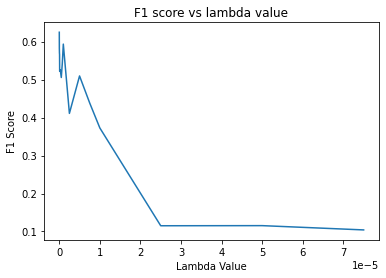

The largest F1 score is 0.6246575342465754 when lambda value is 1e-08
The relative precision score is  0.6263736263736264
The relative recall score is  0.6229508196721312
The relative accuracy score is  0.9672405547584888


In [ ]:
plt.plot(lambda_number, f1_score_lst)
plt.xlabel("Lambda Value")
plt.ylabel("F1 Score")
plt.title("F1 score vs lambda value")
plt.show()
print("The largest F1 score is {} when lambda value is {}".format(max(f1_score_lst), lambda_number[f1_score_lst.index(max(f1_score_lst))]))
print("The relative precision score is ", precision_lst[f1_score_lst.index(max(f1_score_lst))])
print("The relative recall score is ", recall_lst[f1_score_lst.index(max(f1_score_lst))])
print("The relative accuracy score is ", acc_lst[f1_score_lst.index(max(f1_score_lst))])

# Get the reconstructed images for the first 10 samples in the dataset, 10 images with highest reconstruction error and 10 images with lowest reconstruction error

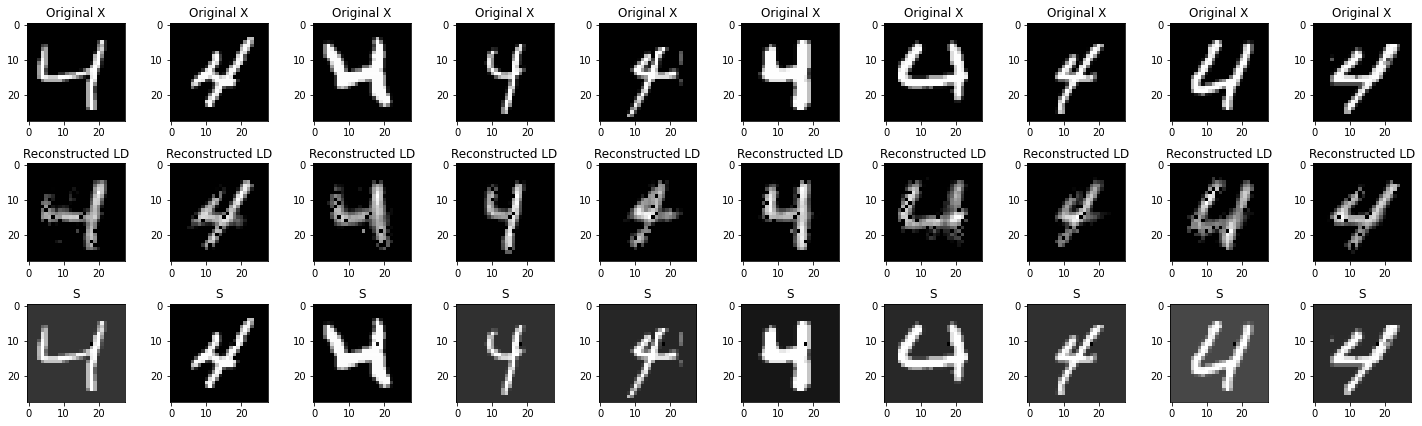

In [ ]:
# Get the output for the largest lambda value
LD = out_dict[5e-8]

# First 10 samples and reconstructed images

plt.figure(figsize=(20, 6))
for index in range(10):
    ax = plt.subplot(3, 10, index+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(3, 10, index+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")
    
    ax = plt.subplot(3, 10, index+21)
    ax.imshow(S[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("S")

plt.tight_layout()

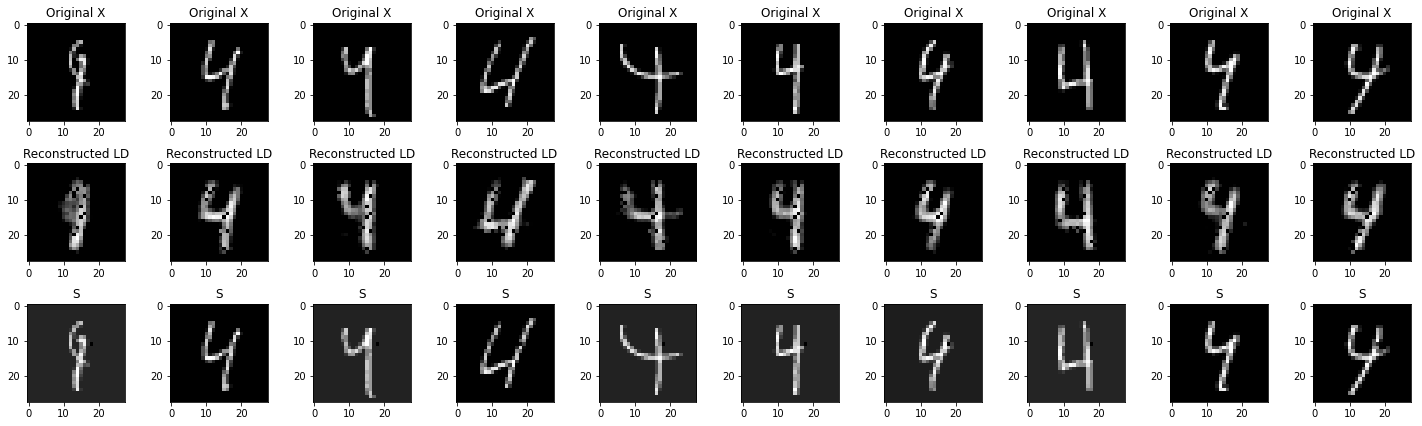

In [ ]:
# 10 images with lowest reconstruction error

plt.figure(figsize=(20, 6))
for n, index in enumerate(np.argsort(recon_error)[:10]):
    ax = plt.subplot(3, 10, n+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(3, 10, n+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")

    ax = plt.subplot(3, 10, n+21)
    ax.imshow(S[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("S")

plt.tight_layout()

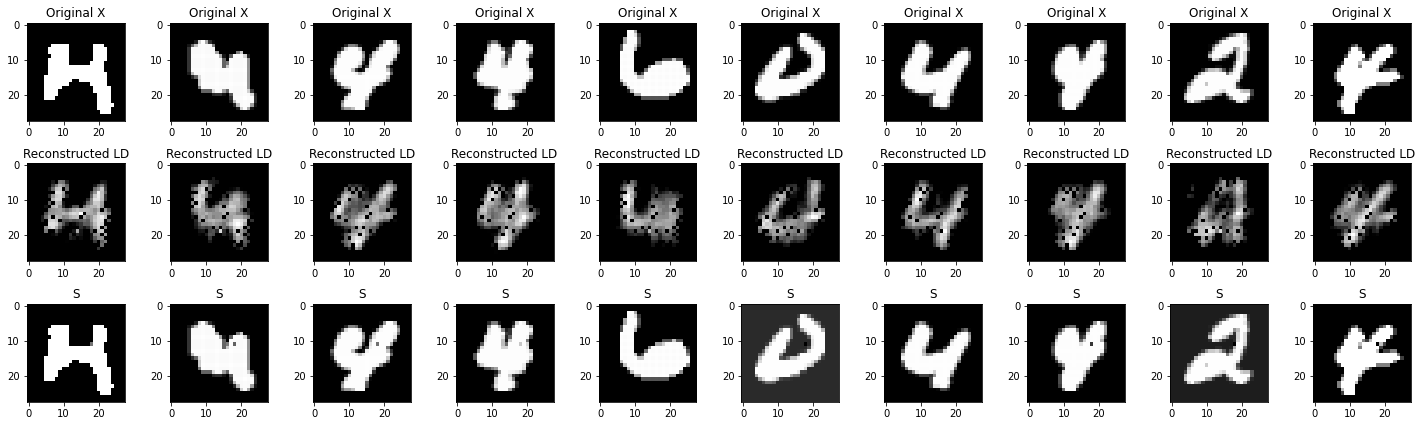

In [ ]:
# 10 images with highest reconstruction error

plt.figure(figsize=(20, 6))
for n, index in enumerate(np.argsort(-recon_error)[:10]):
    ax = plt.subplot(3, 10, n+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(3, 10, n+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")

    ax = plt.subplot(3, 10, n+21)
    ax.imshow(S[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("S")

plt.tight_layout()

## L1 Shrinkage

In [ ]:
# Choose lambda value from 1e-7 to 1e-6 in step of 1e-7

#lambda_number = [x * 1e-8 for x in range(1, 101, 5)]
lambda_number = [1e-8, 2.5e-8, 5e-8, 7.5e-8, 1e-7, 2.5e-7, 5e-7, 7.5e-7, 1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5, 2.5e-5, 5e-5, 7.5e-5]
f1_score_lst = []
precision_lst = []
recall_lst = []
acc_lst = []
out_dict = {}

for lambda_value in lambda_number:

  # initialization
  S = np.zeros((len(xtrain_1), 784))
  output = np.zeros((len(xtrain_1), 784))
  epsilon = 1e-7
  X = np.array(xtrain_1).reshape((len(xtrain_1), 784))
  y = np.array(ytrain_1)
  LS = X

  j = 0

  while j < 300:
    # Define the LD matrix for this step
    LD = X - S

    # Autoencoder step on LD substracted from S
    LD_tensor = torch.from_numpy(LD).float()
    y_tensor = torch.from_numpy(y).float()
    train_dataset = torch.utils.data.TensorDataset(LD_tensor, y_tensor)
    # Create data loader and use batch size = 128
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = False)

    # Initiate the model and use MSE loss, learning rate = 0.001 and epochs = 10
    model = RAE()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    training(model, 10, train_loader)

    # Autoencoder of the step trained, so extraction of the output.
    i = 1
    for input, _ in train_loader:
      input = input.view(-1, 784)
      if i == 1:
        output1 = model(input)
        output1 = output1.detach().numpy()
        output = output1
      else:
        output2 = model(input)
        output2 = output2.detach().numpy()
        output = np.concatenate((output, output2), axis=0)
      i += 1

    """
    LD = np.zeros_like(X)
    i = 0
    for input, _ in train_loader:
      input = input.view(-1, 784)
      output = model(input).detach().numpy()
      LD[i, :] = output
      i += 1
    """

    # Update LD as the reconstruction by the autoencoder
    LD = output

    # Compute S and apply shrinkage.
    S = X - LD
    #S = l12shrinkage(S, lamda=lambda_value)
    S = shrinkage(S, lamda=lambda_value)

    # Increment j for the next step
    j += 1

    # Check for convergence condition
    print('Iteration {}: '.format(j))
    c1 = np.linalg.norm(X - S - LD) / np.linalg.norm(X)
    c2 = np.linalg.norm(LS - S - LD) / np.linalg.norm(X)
    print("c1 = ", c1)
    print("c2 = ", c2)
    print("--------------------------------------------------------")
    if c1 < epsilon or c2 < epsilon:
      print("The training proess has converged and stopped")
      break

    # Update LS for convergence checking in next iteration
    LS = S + LD

  # Store the output of current lambda value in a dictionary
  out_dict[lambda_value] = LD
  # Create the reconstruction error matrix for all samples
  recon_error = np.sqrt(np.sum((X - LD)**2, axis=1))

  # Recon_error follows xtrain_1 indices, so first 4000 values are about digit 4
  # And from 4001 to 4182 it's outliers

  ind_err = np.argsort(-recon_error)  # ordering from largest to smallest
  ind_err2 = np.argsort(recon_error)  # ordering from smallest to largest

  # It is outliers and correctly identified
  # Top 182 largest recon_error should come from indices after 4000
  # So we count how many actual outliers come from the index after 4000
  j = 0
  for k in range(182):
    if ind_err[k] >= 4000:
      j += 1

  # It is NOT outliers and correctly identified
  # We count how many normal samples come from the index before 4000
  m = 0
  for n in range(4000):
    if ind_err2[n] < 4000:
      m += 1

  # Total number of samples
  n = 4182
  # Get the 
  tp = j
  tn = m
  fp = 182 - j
  fn = 4000 - m

  # Calculate the evaluation metrics
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * precision * recall / (precision + recall)

  # Store all the F1 score for different values of lambda
  f1_score_lst.append(f1_score)
  precision_lst.append(precision)
  recall_lst.append(recall)
  acc_lst.append(accuracy)
  print('Training for lambda value {} completed'.format(lambda_value))
  print('------------------------------------------------------------------------')

Iteration 1: 
c1 =  1.0464189e-08
c2 =  1.0464189e-08
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 1e-08 completed
------------------------------------------------------------------------
Iteration 1: 
c1 =  3.6395978e-08
c2 =  3.6395978e-08
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 2.5e-08 completed
------------------------------------------------------------------------
Iteration 1: 
c1 =  7.924411e-08
c2 =  7.924411e-08
--------------------------------------------------------
The training proess has converged and stopped
Training for lambda value 5e-08 completed
------------------------------------------------------------------------
Iteration 1: 
c1 =  1.1501643e-07
c2 =  1.1501643e-07
--------------------------------------------------------
Iteration 2: 
c1 =  1.1598006e-07
c2 =  7.917635e-08
--------------------

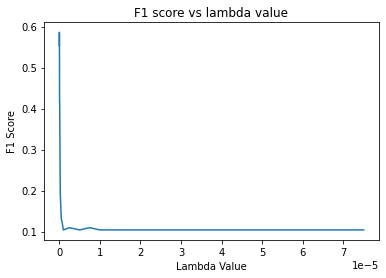

The largest F1 score is 0.5863013698630136 when lambda value is 2.5e-08
The relative precision score is  0.5879120879120879
The relative recall score is  0.5846994535519126
The relative accuracy score is  0.9638928742228599


In [ ]:
plt.plot(lambda_number, f1_score_lst)
plt.xlabel("Lambda Value")
plt.ylabel("F1 Score")
plt.title("F1 score vs lambda value")
plt.show()
print("The largest F1 score is {} when lambda value is {}".format(max(f1_score_lst), lambda_number[f1_score_lst.index(max(f1_score_lst))]))
print("The relative precision score is ", precision_lst[f1_score_lst.index(max(f1_score_lst))])
print("The relative recall score is ", recall_lst[f1_score_lst.index(max(f1_score_lst))])
print("The relative accuracy score is ", acc_lst[f1_score_lst.index(max(f1_score_lst))])

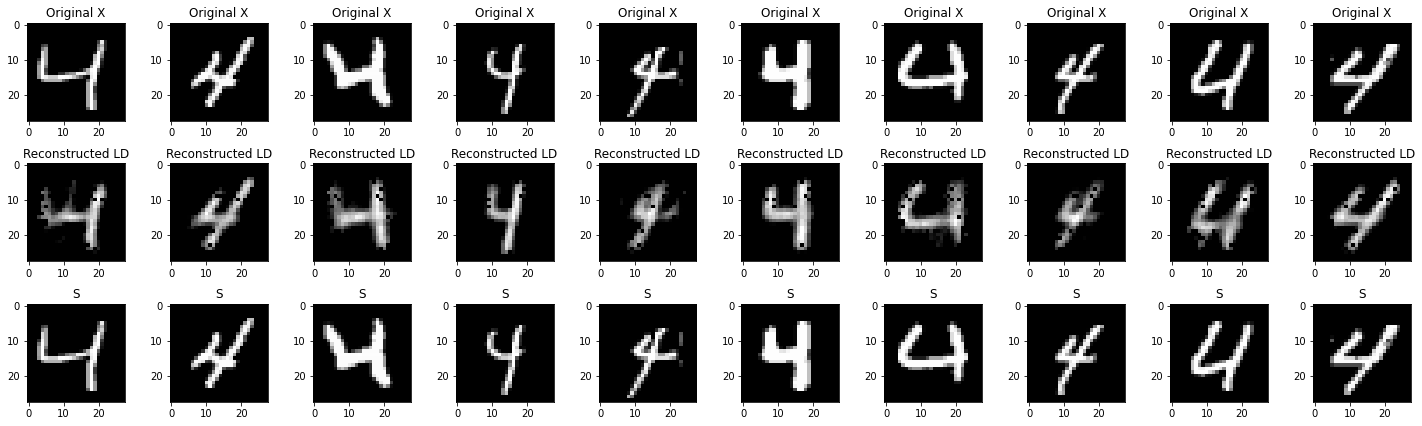

In [ ]:
# Get the output for the largest lambda value
LD = out_dict[2.5e-08]

# First 10 samples and reconstructed images

plt.figure(figsize=(20, 6))
for index in range(10):
    ax = plt.subplot(3, 10, index+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(3, 10, index+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")
    
    ax = plt.subplot(3, 10, index+21)
    ax.imshow(S[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("S")

plt.tight_layout()

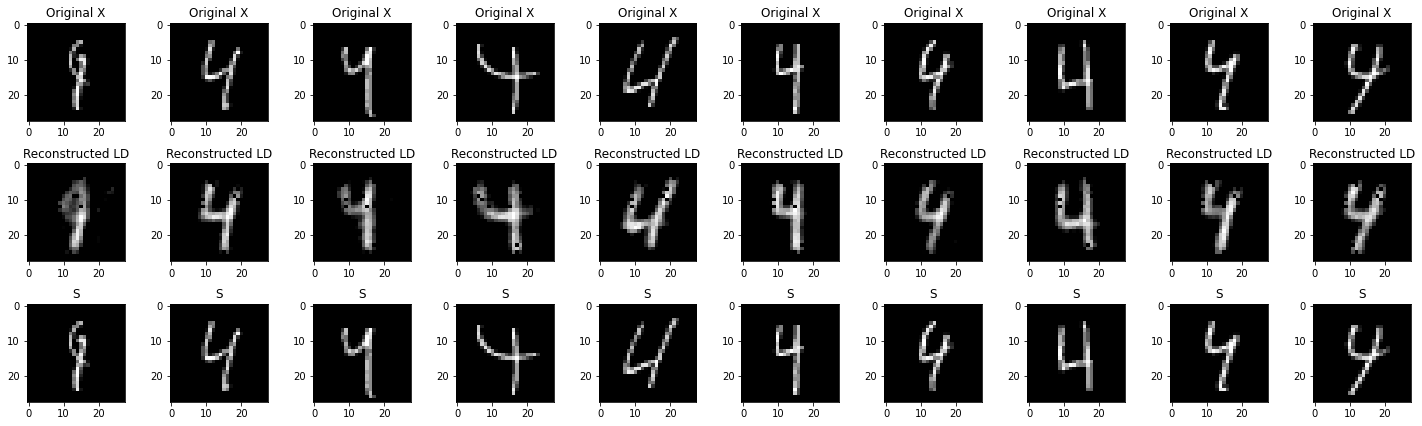

In [ ]:
# 10 images with lowest reconstruction error

plt.figure(figsize=(20, 6))
for n, index in enumerate(np.argsort(recon_error)[:10]):
    ax = plt.subplot(3, 10, n+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(3, 10, n+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")

    ax = plt.subplot(3, 10, n+21)
    ax.imshow(S[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("S")

plt.tight_layout()

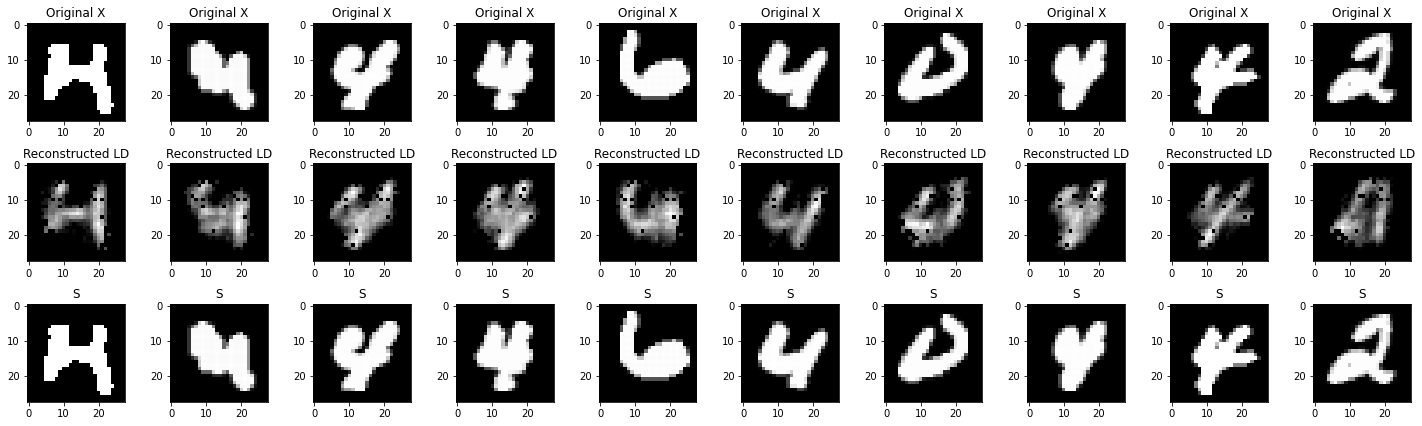

In [ ]:
# 10 images with highest reconstruction error

plt.figure(figsize=(20, 6))
for n, index in enumerate(np.argsort(-recon_error)[:10]):
    ax = plt.subplot(3, 10, n+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(3, 10, n+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")

    ax = plt.subplot(3, 10, n+21)
    ax.imshow(S[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("S")

plt.tight_layout()

# Normal Autoencoder
## Without Shrinkage Process

In [ ]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()
train_dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
# Create data loader and use batch size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = False)

# Initiate the model and use MSE loss, learning rate = 0.001 and epochs = 10
model = RAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training(model, 10, train_loader)

# Autoencoder of the step trained, so extraction of the output.
i = 1
for input, _ in train_loader:
  input = input.view(-1, 784)
  if i == 1:
    output1 = model(input)
    output1 = output1.detach().numpy()
    output = output1
  else:
    output2 = model(input)
    output2 = output2.detach().numpy()
    output = np.concatenate((output, output2), axis=0)
  i += 1

recon_error = np.sqrt(np.sum((X - output)**2, axis=1))

# Recon_error follows xtrain_1 indices, so first 4000 values are about digit 4
# And from 4001 to 4182 it's outliers

ind_err = np.argsort(-recon_error)  # ordering from largest to smallest
ind_err2 = np.argsort(recon_error)  # ordering from smallest to largest

# It is outliers and correctly identified
# Top 182 largest recon_error should come from indices after 4000
# So we count how many actual outliers come from the index after 4000
j = 0
for k in range(182):
  if ind_err[k] >= 4000:
    j += 1

# It is NOT outliers and correctly identified
# We count how many normal samples come from the index before 4000
m = 0
for n in range(4000):
  if ind_err2[n] < 4000:
    m += 1

# Total number of samples
n = 4182
# Get the 
tp = j
tn = m
fp = 182 - j
fn = 4000 - m

# Calculate the evaluation metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
print("The F1 socre is: ", f1_score)
print("The precision is: ", precision)
print("The recall is: ", recall)
print("The accuracy is: ", accuracy)

The F1 socre is:  0.5095890410958904
The precision is:  0.510989010989011
The recall is:  0.5081967213114754
The accuracy is:  0.9571975131516021


# Get the reconstructed images for the first 10 samples in the dataset, 10 images with highest reconstruction error and 10 images with lowest reconstruction error

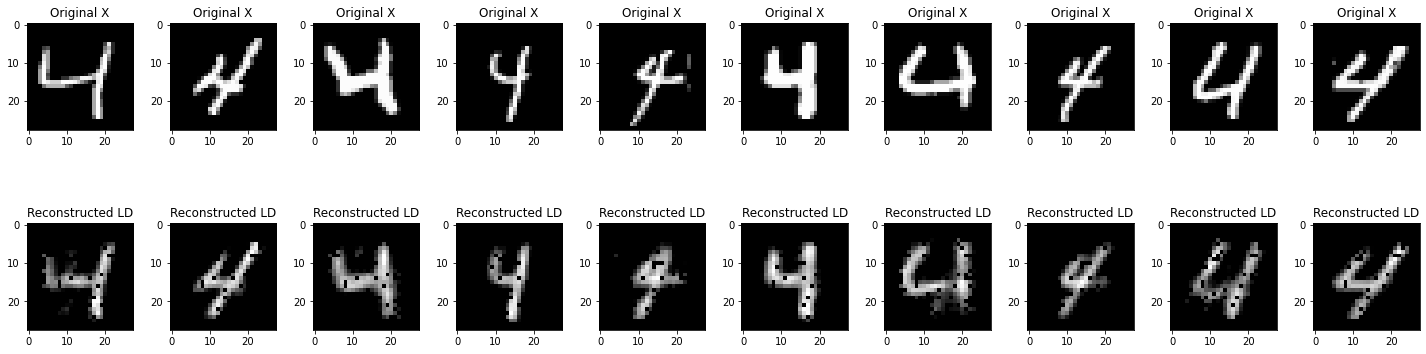

In [ ]:
# First 10 samples and reconstructed images
LD = output

plt.figure(figsize=(20, 6))
for index in range(10):
    ax = plt.subplot(2, 10, index+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(2, 10, index+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")
  
plt.tight_layout()

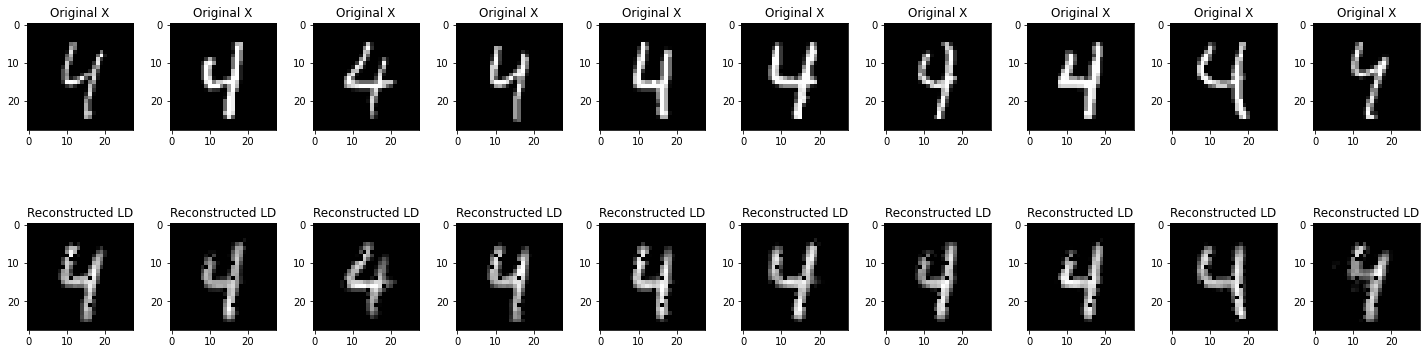

In [ ]:
# 10 images with lowest reconstruction error

plt.figure(figsize=(20, 6))
for n, index in enumerate(np.argsort(recon_error)[:10]):
    ax = plt.subplot(2, 10, n+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(2, 10, n+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")

plt.tight_layout()

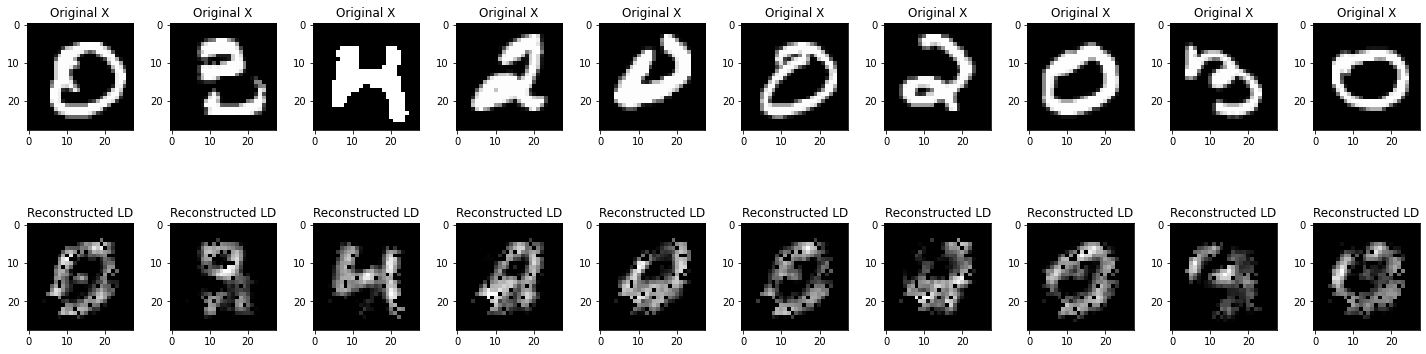

In [ ]:
# 10 images with highest reconstruction error

plt.figure(figsize=(20, 6))
for n, index in enumerate(np.argsort(-recon_error)[:10]):
    ax = plt.subplot(2, 10, n+1)
    ax.imshow(X[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Original X")

    ax = plt.subplot(2, 10, n+11)
    ax.imshow(LD[index].reshape(28, 28), cmap = 'gray')
    ax.title.set_text("Reconstructed LD")

plt.tight_layout()